In [1]:
%matplotlib widget

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from bouter.embedded import EmbeddedExperiment
from pathlib import Path
from scipy.ndimage import generic_filter
from tqdm import tqdm
from scipy import signal
from scipy.signal import savgol_filter as sgf
import flammkuchen as fl
from scipy.ndimage import zoom,generic_filter
from scipy.stats import sem
import seaborn as sns
from scipy.stats import zscore, mannwhitneyu
import random
from matplotlib import cm
from scipy.signal import medfilt

In [3]:
def compute_temporal_pturn(df_,bins,th=np.deg2rad(30)):
    out_ = np.zeros(bins.shape[0]-1)
    t_start = df_["t_start"].values
    t_start[t_start>1260] -= 1260
    t_start[t_start>1260] -= 1260
    for n_bin,(start_,end_) in enumerate(zip(bins[:-1],bins[1:])):
        bouts_in_bin = (t_start>=start_)&(t_start<end_)
        bias = abs(df_["bias"].values[bouts_in_bin])
        out_[n_bin] = np.sum(bias>=th) / bias.shape[0]
    return out_

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh) 

In [4]:
plt.rcParams.update({'font.size': 25})

In [10]:
master_path = Path(r"Z:\Ruben\from MPIN\J-E0041_temperature\ls_1120\data")
list_files = list(master_path.glob("*_f*"))

In [6]:
temp_traces = []
for i in tqdm(range(len(list_files))):
    exp = EmbeddedExperiment(list_files[i])
    trace = np.interp(np.linspace(0,3780,3780),exp.stimulus_log["t"],exp.stimulus_log["s0_u3_dyn_volt_stim_voltage_in_thermo"])*10
    temp_traces.append(trace)
temp_traces = np.stack(temp_traces)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 16.50it/s]


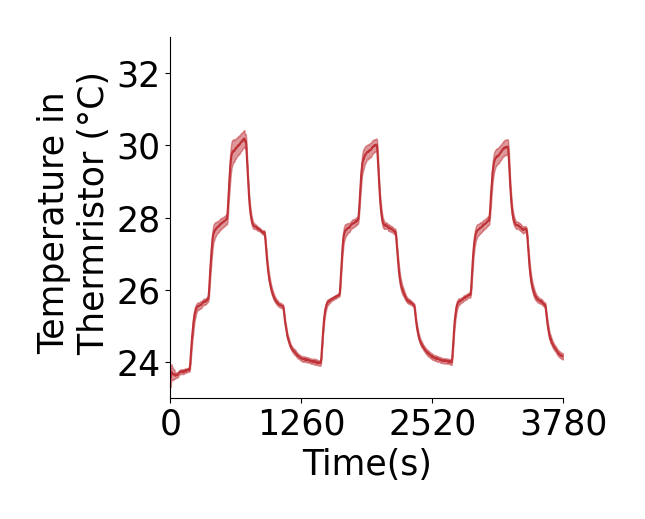

In [13]:
x_ = np.linspace(0,3780,3780)
plt.figure()
plt.plot(x_,np.nanmean(temp_traces,0),c=plt.cm.RdBu_r(220))
plt.fill_between(x_,np.nanmean(temp_traces,0)-sem(temp_traces,0),
                np.nanmean(temp_traces,0)+sem(temp_traces,0),alpha=.5,color=plt.cm.RdBu_r(220))
plt.ylabel("Temperature in \n Thermristor (°C)",fontsize=25)
plt.xlabel("Time(s)",fontsize=25)
plt.xticks([0,1260,1260*2,1260*3])
plt.ylim([23,33])
plt.xlim([0,1260*3])
plt.yticks([24,26,28,30,32])
sns.despine()
set_size(5,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\supp_3_II.png",dpi=800)

In [14]:
exp = EmbeddedExperiment(list_files[7])
bouts = exp.get_bout_properties()
t_ = bouts["t_start"].values
t_[t_>1260] -= 1260
t_[t_>1260] -= 1260

In [11]:
datas = []
for i in tqdm(range(len(list_files))):
    exp = EmbeddedExperiment(list_files[i])

    bouts = exp.get_bout_properties()
    datas.append(bouts)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:23<00:00,  2.12s/it]


In [18]:
intervals = [0,182,361,540,720,902,1081,1200]
temp_intervals = [24,26,28,30,28,26,24]

In [20]:
intervals = np.array([200,533,768,1078])

In [21]:
temp_bins = np.array(intervals)
turn_t_start = []
for data in tqdm(datas):
    pturn = compute_temporal_pturn(data.copy(),intervals)
    t_ = data["t_start"].values[abs(data["bias"])>np.deg2rad(30)]
    t_[t_>1260] -= 1260
    t_[t_>1260] -= 1260
    turn_t_start.append(t_)
turn_t_start = np.concatenate(turn_t_start)

100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1100.79it/s]


In [22]:
bins_plot = (temp_bins[1:]+temp_bins[:-1])/2

In [23]:
mapped_color = np.interp(np.array(temp_intervals)-25.280104571722397,[-5,5],[0,1])

In [12]:
intervals = np.array([200,533,768,1078])

In [25]:
temp_bins = np.array(intervals)
cxt_index = []
for data in tqdm(datas):
    pturn = compute_temporal_pturn(data.copy(),intervals)
#     t_ = data["t_start"].values[abs(data["bias"])>np.deg2rad(30)]
    pturn = pturn[0] - pturn[-1]
    cxt_index.append(pturn)
cxt_index = np.array(cxt_index)

100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 2201.52it/s]


In [31]:
print(mannwhitneyu(cxt_index,np.zeros(cxt_index.shape[0]))[1])

0.0038337218332901604


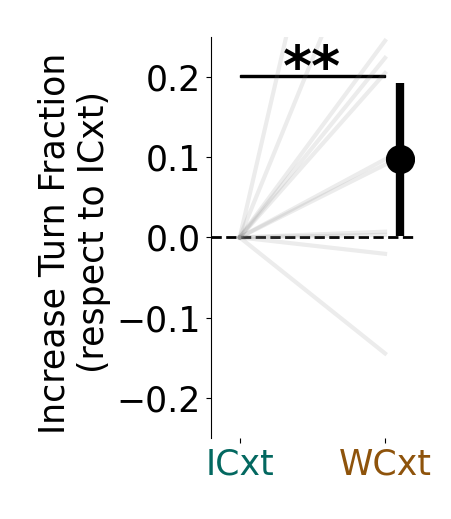

In [78]:
bins_center = np.array([1.1])
plt.figure()
plt.plot([-.2,1.2],[0,0],"--",color="k",lw=2)
plt.plot(np.stack([np.zeros(cxt_index.shape[0]),cxt_index]),c="gray",alpha=.15,lw=3)
plt.errorbar(bins_center,np.nanmedian(cxt_index,0),
             yerr=sem(cxt_index,0,nan_policy="omit")*1.23,
            lw=6,fmt="-",ms=14,marker="o",mew=7,c="k",
            capthick=5)

plt.axvspan(0,1,.9,.905,color="k")
plt.text(.3,0.19,"**",color="k",fontsize=40,fontweight="bold")

plt.ylabel("Increase Turn Fraction \n (respect to ICxt)",fontsize=25)
plt.xticks([0,1],["ICxt","WCxt"],fontsize=25)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), ["#036860","#8e530b"]):
    ticklabel.set_color(tickcolor)
plt.ylim([-.25,.25])
plt.yticks([-.2,-.1,0,.1,.2],fontsize=25)
plt.xlim([-.2,1.2])
sns.despine(bottom=True)
set_size(3.5,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\supp_3_e.png",dpi=800)

In [8]:
def spk_vect(t_events, events):
    zeros_vect = np.zeros(int(4000)*10+1)
    new_time_vect = np.linspace(0,t_events[-1],int(t_events[-1])*10)
    zeros_vect[t_events.astype(int)*10] = events
    return new_time_vect,zeros_vect[:-1]

In [10]:
filter_size = 30
turn_rates = []
fwd_rates = []
for data, path_ in tqdm(zip(datas,list_files)):
    in_exp = data["t_start"].values <= 3600
    thetas = data["bias"]
    are_t = abs(thetas)>np.deg2rad(30)
    t_ev_bias, ev_ = spk_vect(data["t_start"].values[are_t&in_exp],np.ones(np.sum(are_t&in_exp)))
    t_rate = generic_filter(generic_filter(ev_,np.nansum,2*filter_size),np.nanmean,2*filter_size)
    are_f = abs(thetas)<=np.deg2rad(30)
    t_ev_bias, ev_ = spk_vect(data["t_start"].values[are_f&in_exp],np.ones(np.sum(are_f&in_exp)))
    f_rate = generic_filter(generic_filter(ev_,np.nansum,2*filter_size),np.nanmean,2*filter_size)
    fl.save(path_/"rates.h5",{"forward":f_rate,
                              "turn":t_rate})

1it [00:05,  5.87s/it]


In [11]:
turn_rates = []
fwd_rates = []
for path_ in tqdm(list_files):
    dict_ = fl.load(path_/"rates.h5")
    turn_rates.append(dict_["turn"])
    fwd_rates.append(dict_["forward"])

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 62.22it/s]


In [13]:
time_vector_rates = np.linspace(0,3600, len(fwd_rates[1]))

In [17]:
off_ = int(500*10)
trials_avg = np.zeros((len(turn_rates),2,off_*2))
first_ramp = np.argmin(abs(time_vector_rates-621))
second_ramp = np.argmin(abs(time_vector_rates-1820))
third_ramp = np.argmin(abs(time_vector_rates-3020))
for i_fish in range(len(turn_rates)):

    trial_avg_t = np.nanmean(np.stack([zscore(turn_rates[i_fish][first_ramp-off_:first_ramp+off_]),
                                     zscore(turn_rates[i_fish][second_ramp-off_:second_ramp+off_]),
                                     zscore(turn_rates[i_fish][third_ramp-off_:third_ramp+off_])],0),0)
    
    trial_avg_f = np.nanmean(np.stack([zscore(fwd_rates[i_fish][first_ramp-off_:first_ramp+off_]),
                                     zscore(fwd_rates[i_fish][second_ramp-off_:second_ramp+off_]),
                                     zscore(fwd_rates[i_fish][third_ramp-off_:third_ramp+off_])],0),0)
    trials_avg[i_fish,0,:] =  trial_avg_t
    trials_avg[i_fish,1,:] =  trial_avg_f

In [18]:
time_vector_stim = np.linspace(0,1000, 1000)
time_vector_rates_plot = np.linspace(0,1000, 1000*10)

C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator


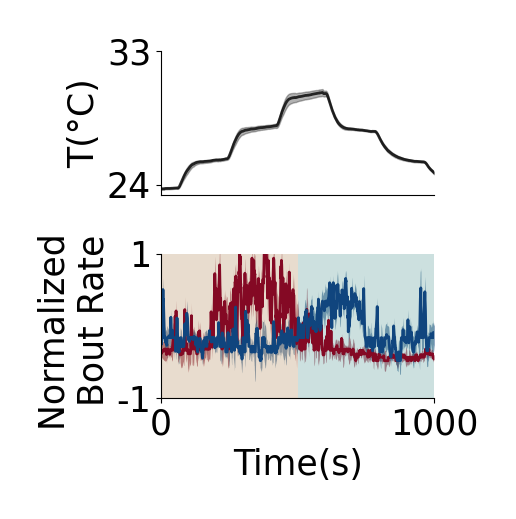

In [20]:
f,a = plt.subplots(2,1)

a[0].plot(time_vector_stim,np.nanmean(temp_traces[:,621-500:621+500],0),c="k",lw=2,alpha=.8)

a[0].fill_between(time_vector_stim,np.nanmean(temp_traces[:,621-500:621+500],0)-sem(temp_traces[:,621-500:621+500],0),
                np.nanmean(temp_traces[:,621-500:621+500],0)+sem(temp_traces[:,621-500:621+500],0),alpha=.3,color="k")

a[0].set_xlim([0,1000])
a[0].set_xticks([])
a[0].set_yticks([24,33])
a[0].set_yticklabels([24,33], fontsize=25)
a[0].set_ylabel("T(°C)", fontsize=25)

a[1].plot(time_vector_rates_plot,np.nanmedian(trials_avg[:,0,:],0),color=cm.RdBu(10),lw=2)
a[1].fill_between(time_vector_rates_plot,
                  np.nanmedian(trials_avg[:,0,:],0)-(sem(trials_avg[:,0,:],0,0,nan_policy="omit")),
                 np.nanmedian(trials_avg[:,0,:],0)+(sem(trials_avg[:,0,:],0,0,nan_policy="omit")),
                  color=cm.RdBu(10),lw=0,alpha=.5)
a[1].plot(time_vector_rates_plot,np.nanmedian(trials_avg[:,1,:],0),color=cm.RdBu(245),lw=2)
a[1].fill_between(time_vector_rates_plot,
                  np.nanmedian(trials_avg[:,1,:],0)-(sem(trials_avg[:,1,:],0,0,nan_policy="omit")),
                 np.nanmedian(trials_avg[:,1,:],0)+(sem(trials_avg[:,1,:],0,0,nan_policy="omit")),
                  color=cm.RdBu(245),lw=0,alpha=.5)
a[1].axvspan(0,500,color="#8e530b",alpha=.2,lw=0)
a[1].axvspan(500,1000,color="#036860",alpha=.2,lw=0)

a[1].set_xlim([0,1000])
a[1].set_xticks([0,1000])
a[1].set_yticklabels([0,1000], fontsize=25)
a[1].set_ylim([-1,1])
a[1].set_yticks([-1,1])
a[1].set_yticklabels([-1,1], fontsize=25)
a[1].set_xlabel("Time(s)", fontsize=25)
a[1].set_ylabel("Normalized \n Bout Rate", fontsize=25)
set_size(4,4)
sns.despine()
plt.tight_layout()
plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\3_a_new.png",dpi=800)
plt.show()

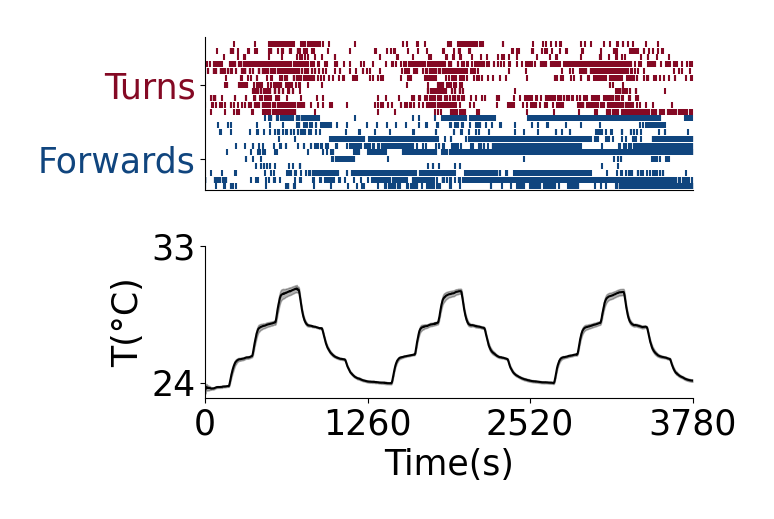

In [84]:
dot_lines = [643,1919,3159]
f,a = plt.subplots(2,1)
off_ = 1
    
for data in datas:
    are_f = abs(data["bias"].values)<=np.deg2rad(30)
    a[0].scatter(data["t_start"].values[are_f],np.ones(np.sum(are_f))*off_,
                color=cm.RdBu(245),marker="|",s=20)
    off_ += 1

for data in datas:
    are_t = abs(data["bias"].values)>np.deg2rad(30)
    a[0].scatter(data["t_start"].values[are_t],np.ones(np.sum(are_t))*off_,
                color=cm.RdBu(10),marker="|",s=20)
    off_ += 1


a[0].set_xticks([])
a[0].set_ylim([0.5,11.5*2])
a[0].set_yticks([5,16])
a[0].set_yticklabels(["Forwards","Turns"],fontsize=25)

for ticklabel, tickcolor in zip(a[0].get_yticklabels(), [cm.RdBu(245),cm.RdBu(10)]):
    ticklabel.set_color(tickcolor)

a[0].set_xlim([0,1260*3])
# a[0].set_xlabel("Time(s)")
# a[0].set_ylabel("Bout Events")

# for l_ in dot_lines:
#     a[1].plot([l_,l_],[23,33],"--k",alpha=1,lw=1)
    
x_ = np.linspace(0,3780,3780)
a[1].plot(x_,np.nanmean(temp_traces,0),c="k")
a[1].fill_between(x_,np.nanmean(temp_traces,0)-sem(temp_traces,0),
                np.nanmean(temp_traces,0)+sem(temp_traces,0),alpha=.3,color="k")
a[1].set_ylabel("T(°C)",fontsize=25)
a[1].set_xlabel("Time(s)",fontsize=25)
a[1].set_xticks([0,1260,1260*2,1260*3])
a[1].set_ylim([23,33])
a[1].set_xlim([0,1260*3])
a[1].set_yticks([24,33])

sns.despine()

set_size(6,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\3_d_v02.png",dpi=800)

In [289]:
def compute_temporal_pipsi(df_,bins,th=np.deg2rad(30)):
    out_ = np.zeros(bins.shape[0]-1)
    theta_each_bout = df_["bias"].values
    two_cons_turns = (abs(theta_each_bout[:-1])>=th)
    ipsi = theta_each_bout[1:][two_cons_turns]*np.sign(theta_each_bout[:-1][two_cons_turns])
    t_start = df_["t_start"].values[1:][two_cons_turns]
    t_start[t_start>1200] -= 1200
    t_start[t_start>1200] -= 1200
    print(bins)
    for n_bin,(start_,end_) in enumerate(zip(bins[:-1],bins[1:])):
        bouts_in_bin = (t_start>=start_)&(t_start<end_)
        pipsi = np.nanmean(ipsi[bouts_in_bin],0)
        out_[n_bin] = pipsi
    return out_

def compute_temporal_pipsi_rand(df_,bins,th=np.deg2rad(30), n_reps=20):
    out_final = []
    for _ in range(n_reps):
        out_ = np.zeros(bins.shape[0]-1)
        theta_each_bout = df_["bias"].values
        two_cons_turns = (abs(theta_each_bout[:-1])>=th)
        prev_rand = random.choices(np.array([-1,1]),np.array([.5,.5]),k=theta_each_bout[1:][two_cons_turns].shape[0])
        ipsi = theta_each_bout[1:][two_cons_turns]*prev_rand
        t_start = df_["t_start"].values[1:][two_cons_turns]
        t_start[t_start>1200] -= 1200
        t_start[t_start>1200] -= 1200
        for n_bin,(start_,end_) in enumerate(zip(bins[:-1],bins[1:])):
            bouts_in_bin = (t_start>=start_)&(t_start<end_)
            pipsi = np.nanmean(ipsi,0)
            out_[n_bin] = pipsi
        out_final.append(out_)
    return np.stack(out_final,0).mean(0)

def compute_temporal_pipsiandtime(df_,bins,th=np.deg2rad(30), temporal_bins=np.linspace(0,30,3)):
    theta_each_bout = df_["bias"].values
    two_cons_turns = (abs(theta_each_bout[:-1])>=th)
    ipsi = theta_each_bout[:-1][two_cons_turns]*np.sign(theta_each_bout[1:][two_cons_turns])
    t_start = df_["t_start"].values[1:][two_cons_turns]
    difft_with_prec = df_["t_start"][1:].values[two_cons_turns] - df_["t_start"].values[:-1][two_cons_turns]
    t_start[t_start>1200] -= 1200
    t_start[t_start>1200] -= 1200
    

    bouts_in_bin = (t_start>=bins[0])&(t_start<bins[1])
    out_ = np.zeros((np.sum(bouts_in_bin),2))
    out_[:,0] = ipsi[bouts_in_bin]
    out_[:,1] = difft_with_prec[bouts_in_bin]
    
    fraction_ipsi = []
    num_events = []
    temporal_bins = np.linspace(0,9,6)
    
    for s_,e_ in zip(temporal_bins[:-1],temporal_bins[1:]):
        in_bin = (out_[:,1] >= s_)&(out_[:,1] < e_)
        if np.sum(in_bin)>0:
#             num_ipsi = np.sum(out_[in_bin,0]>0) / np.sum(in_bin)
            num_ipsi = np.nanmedian(out_[in_bin,0])
            fraction_ipsi.append(num_ipsi)
            num_events.append(np.sum(in_bin))
        else:
            fraction_ipsi.append(np.nan)
            num_events.append(np.nan)
    
    return fraction_ipsi,num_events

In [284]:
temp_bins = np.array(intervals)
ipsi_time_WT_T = []
num_events_time_WT_T = []
for data in datas:
    pipsiT,neT = compute_temporal_pipsiandtime(data,temp_bins)
    ipsi_time_WT_T.append(pipsiT)
    num_events_time_WT_T.append(neT)
ipsi_time_WT_T = np.stack(ipsi_time_WT_T,0)
num_events_time_WT_T = np.stack(num_events_time_WT_T,0)

In [91]:
# fraction_ipsi = []
# temporal_bins = np.linspace(0,10,5)
# bins_plot = (temporal_bins[:-1]+temporal_bins[1:])/2
# for s_,e_ in zip(temporal_bins[:-1],temporal_bins[1:]):
#     in_bin = (ipsi_time_WT_T[:,1] >= s_)&(ipsi_time_WT_T[:,1] < e_)
#     num_ipsi = np.sum(ipsi_time_WT_T[in_bin,0]>0) / np.sum(in_bin)
#     fraction_ipsi.append(num_ipsi)

In [285]:
temporal_bins = np.linspace(0,9,6)
bins_plot = (temporal_bins[:-1]+temporal_bins[1:])/2

C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  


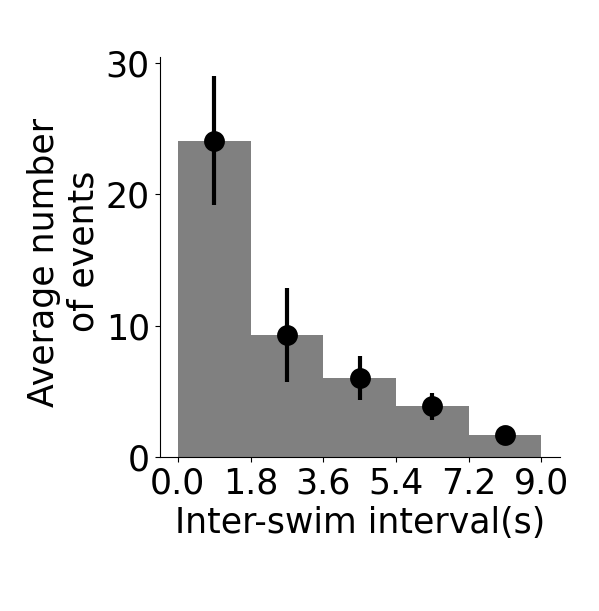

In [275]:
plt.figure()
plt.bar(bins_plot,
        np.nanmean(num_events_time_WT_T,0),
        color="gray", width=temporal_bins[1])
plt.errorbar(bins_plot,np.nanmean(num_events_time_WT_T,0),
             yerr=sem(num_events_time_WT_T,0,nan_policy="omit"),
            lw=3,fmt="o",ms=10,marker="o",mew=5,c="k",
            capthick=5)
plt.yticks([0,10,20,30], fontsize=25)
plt.ylabel("Average number \n of events", fontsize=25)
plt.xticks(np.round(temporal_bins,1),fontsize=25)
plt.xlabel("Inter-swim interval(s)", fontsize=25)
plt.tight_layout()
sns.despine()
set_size(4,4)

plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\figures_reviews\rev1_point1_0.png",dpi=800)

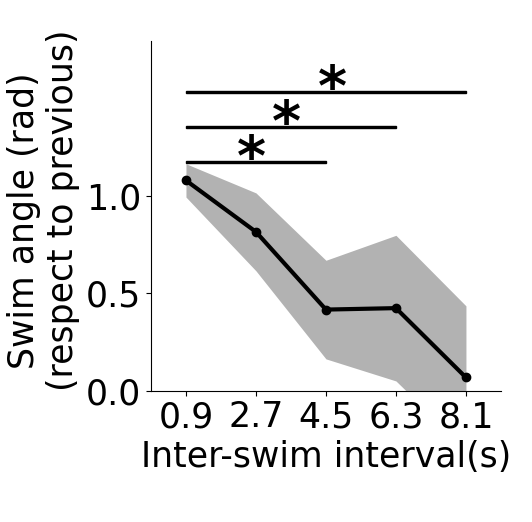

In [346]:
plt.figure()
plt.fill_between(bins_plot,
                 np.nanmean(ipsi_time_WT_T,0)-sem(ipsi_time_WT_T,0,nan_policy="omit"),
                  np.nanmean(ipsi_time_WT_T,0)+sem(ipsi_time_WT_T,0,nan_policy="omit")
                ,color="k",alpha=.3,lw=0)
plt.plot(bins_plot,
        np.nanmean(ipsi_time_WT_T,0),"-o",
        color="k",lw=3)

plt.axvspan(.9,4.5,.65,.655,color="k")
plt.text(2.2,1.11,"*",color="k",fontsize=40,fontweight="bold")

plt.axvspan(.9,6.3,.75,.755,color="k")
plt.text(3.1,1.29,"*",color="k",fontsize=40,fontweight="bold")

plt.axvspan(.9,8.1,.85,.855,color="k")
plt.text(4.3,1.47,"*",color="k",fontsize=40,fontweight="bold")

plt.yticks([0,.5,1], fontsize=25)
plt.ylim([0,1.8])
plt.xlim([0,9])
plt.ylabel("Swim angle (rad) \n (respect to previous)",fontsize=25)
plt.xticks(np.round(bins_plot,1),fontsize=25)
plt.xlabel("Inter-swim interval(s)", fontsize=25)
plt.tight_layout()
sns.despine()
set_size(3.5,3.5)
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\figures_reviews\rev1_point1_1_LS.png",dpi=800)

In [347]:
pvals = []
for i in range(1,5):
    print(mannwhitneyu(ipsi_time_WT_T[:,0][np.isfinite(ipsi_time_WT_T[:,0])],
                       ipsi_time_WT_T[:,i][np.isfinite(ipsi_time_WT_T[:,i])])[1])

0.5974062696275562
0.0211339281291611
0.03301110654051831
0.03301110654051831


In [290]:
temp_bins = np.array(intervals)
ipsi_index_WT = []
ipsi_index_WT_random = []
for data in datas:
    pipsi = compute_temporal_pipsi(data,temp_bins)
    pipsi_rand = compute_temporal_pipsi_rand(data,temp_bins)
    ipsi_index_WT.append(pipsi[0])
    ipsi_index_WT_random.append(pipsi_rand[0])
ipsi_index_WT = np.stack(ipsi_index_WT)
ipsi_index_WT_random = np.stack(ipsi_index_WT_random)

[ 200  533  768 1078]
[ 200  533  768 1078]
[ 200  533  768 1078]
[ 200  533  768 1078]
[ 200  533  768 1078]
[ 200  533  768 1078]
[ 200  533  768 1078]
[ 200  533  768 1078]
[ 200  533  768 1078]
[ 200  533  768 1078]
[ 200  533  768 1078]


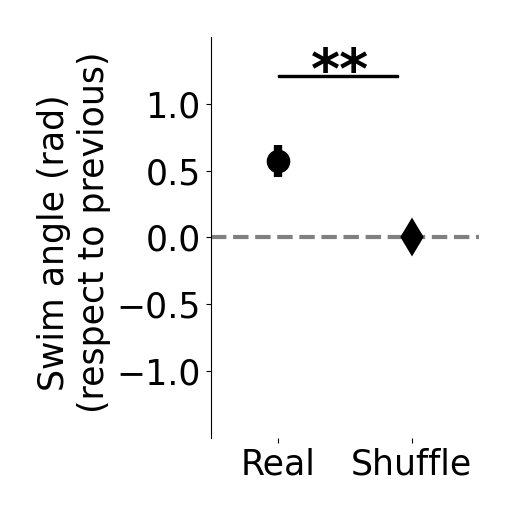

In [301]:
plt.figure(figsize=(3,5))
plt.plot([-3.5,-1.5],[0,0],"--",c="gray",lw=3)
to_plot = ipsi_index_WT.copy()
plt.errorbar([-3],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=10,marker="o",mew=7,c="k",
            capthick=5)

to_plot = ipsi_index_WT_random.copy()
plt.errorbar([-2],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=10,marker="d",mew=7,c="k",
            capthick=5)

plt.axvspan(-3,-2.1,.9,.905,color="k")
plt.text(-2.75,1.12,"**",color="k",fontsize=40,fontweight="bold")

plt.xlim([-3.5,-1.5])
plt.ylim([-1.5,1.5])
plt.yticks([-1,-.5,0,.5,1],fontsize=25)
plt.xticks([-3,-2],["Real","Shuffle"],fontsize=25)
plt.ylabel("Swim angle (rad) \n (respect to previous)",fontsize=25)
sns.despine(bottom=True)
set_size(4,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\figures_reviews\new_supp_3f.png",dpi=800)

In [293]:
print(mannwhitneyu(ipsi_index_WT,ipsi_index_WT_random)[1])

0.0012927447796956875


In [61]:
def spk_vect(t_events, events):
    zeros_vect = np.zeros(int(t_events[-1])*1000+1)
    new_time_vect = np.linspace(0,t_events[-1],int(t_events[-1])*1000)
    zeros_vect[t_events.astype(int)*1000] = events
    return new_time_vect,zeros_vect[:-1]

In [62]:
#2
exp = EmbeddedExperiment(list_files[6])
bouts = exp.get_bout_properties()

In [63]:
t_theta, theta = spk_vect(bouts["t_start"].values,bouts["bias"].values)

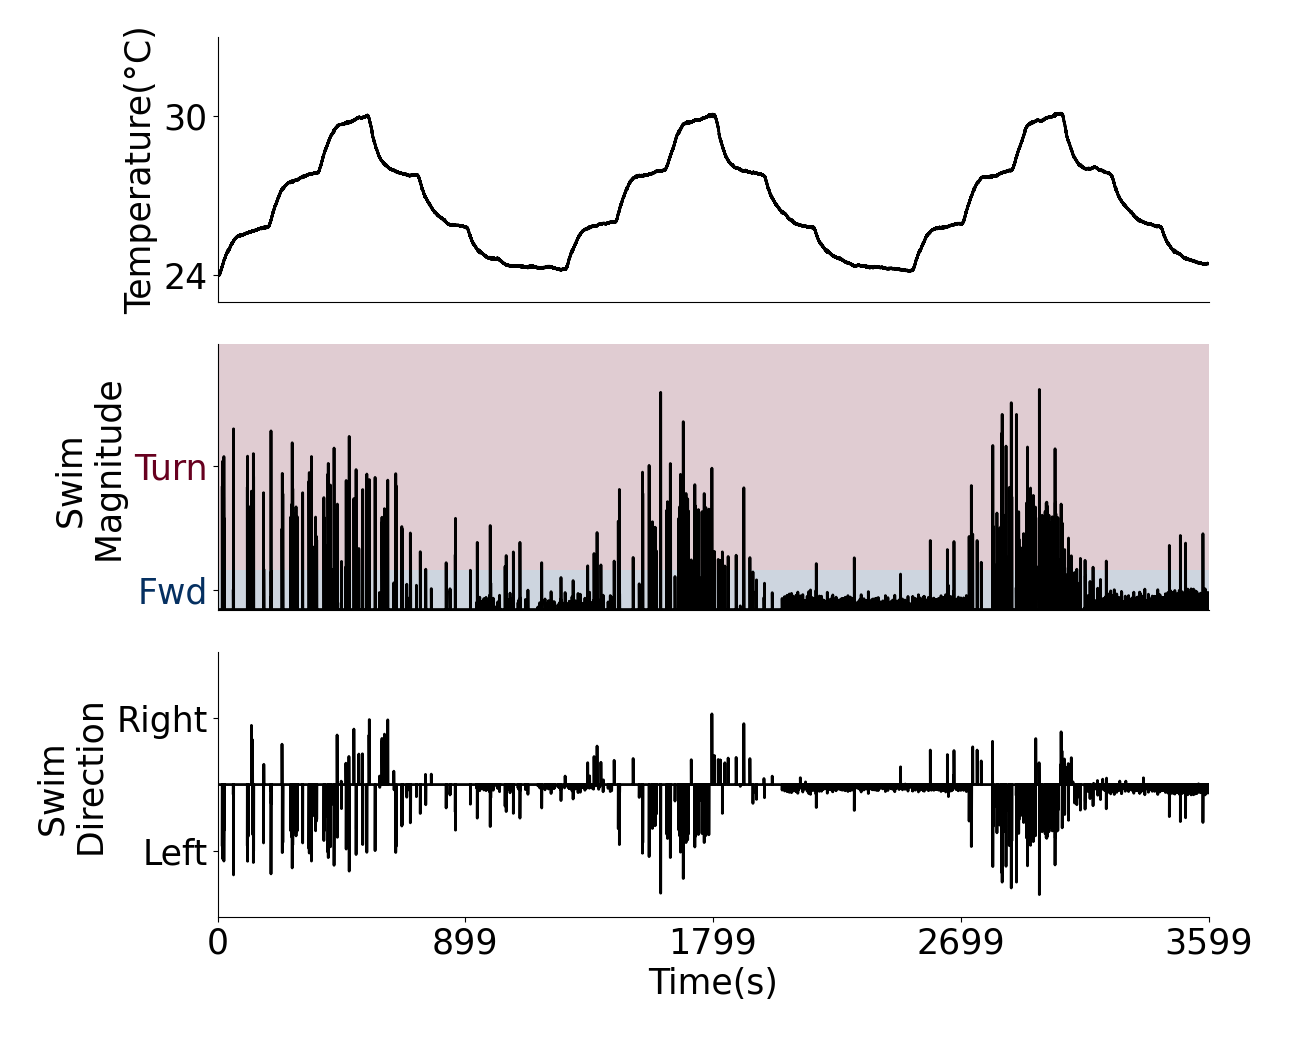

In [79]:
f,a = plt.subplots(3,1,figsize=(9,7))
a[0].plot(exp.stimulus_log["t"],exp.stimulus_log["s0_u3_dyn_volt_stim_voltage_in_thermo"]*10,"-",lw=2,c="k")
a[0].set_ylim([23,33])
a[0].set_yticks([24,33])
a[0].set_yticklabels(["24","33"],fontsize=25)
a[0].set_ylabel("Temperature(°C)",fontsize=25)
a[0].set_xticks([])
a[1].plot(t_theta, abs(theta),"-",lw=2,c="k",alpha=1)

a[1].axhspan(np.deg2rad(30),np.deg2rad(200),color=cm.RdBu(0),alpha=.2,lw=0)
a[1].axhspan(0,np.deg2rad(30),color=cm.RdBu(255),alpha=.2,lw=0)

a[1].set_ylim([0,np.deg2rad(200)])
a[1].set_yticks([np.deg2rad(15),np.deg2rad(108)])
a[1].set_yticklabels(["Fwd","Turn"],fontsize=25)

for ticklabel, tickcolor in zip(a[1].get_yticklabels(), [cm.RdBu(255),cm.RdBu(0)]):
    ticklabel.set_color(tickcolor)
    
a[1].set_ylabel("Swim \n Magnitude",fontsize=25)
a[1].set_xticks([])
a[2].plot(t_theta, theta,"-",lw=2,c="k",alpha=1)
a[2].set_ylim([-np.deg2rad(200),np.deg2rad(200)])
a[2].set_yticks([-np.deg2rad(100),np.deg2rad(100)])
a[2].set_yticklabels(["Left","Right"],fontsize=25)
a[2].set_ylabel("Swim \n Direction",fontsize=25)


for i in range(3):
    a[i].set_xlim([180,exp.stimulus_log["t"].values[-1]])
a[-1].set_xlabel("Time(s)",fontsize=25)
a[-1].set_xticks(np.linspace(180,exp.stimulus_log["t"].values[-1],5).astype(int),
                np.linspace(0,exp.stimulus_log["t"].values[-1]-180,5).astype(int))
a[-1].set_xticklabels(np.linspace(0,exp.stimulus_log["t"].values[-1]-180,5).astype(int),fontsize=25)
sns.despine()
set_size(10,8)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\3_a.png",dpi=800)